In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image 

In [2]:
#Transforming images according to required specifications.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './Data/training_images/'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Total number of samples: {len(dataset)}")

Total number of samples: 16540


In [3]:
#Setting up the Pre-trained ResNet model.
#Setting up GPU.

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("Model is ready for feature extraction.")

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is ready for feature extraction.


In [4]:
#Feature Extraction using ResNet18.
#Saving extracted features to Data.

from tqdm import tqdm

features = []
labels = []

model.eval()

with torch.no_grad():
    for images, lbls in tqdm(data_loader, desc="Extracting Features"):
        images = images.to(device)
        outputs = model(images)
        features.append(outputs.cpu())
        labels.append(lbls)

features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

torch.save(features, './Data/extracted_features.pt')
torch.save(labels, './Data/extracted_labels.pt')

Extracting Features: 100%|██████████| 517/517 [11:57<00:00,  1.39s/it]


In [7]:
#Loading extracted features.

features = torch.load('./Data/extracted_features.pt')
labels = torch.load('./Data/extracted_labels.pt')

In [8]:
#Converting features into a numpy array.
#Fitting PCA on features.

from sklearn.decomposition import PCA
features_np = features.numpy()

n_components = 50
pca = PCA(n_components=n_components)

features_pca = pca.fit_transform(features_np)

print(f"Original feature shape: {features_np.shape}")
print(f"Reduced feature shape: {features_pca.shape}")

Original feature shape: (16540, 512)
Reduced feature shape: (16540, 50)


In [9]:
#Extracting explained variance ratio for each principle component.
#Calculating cumalative variance explained by all (50) principle components.

explained_variance_ratio = pca.explained_variance_ratio_

print(f"Explained variance ratio: {explained_variance_ratio}")
print(f"Total variance explained by {n_components} components: {sum(explained_variance_ratio):.2f}")

Explained variance ratio: [0.04094619 0.0348784  0.03036751 0.02531622 0.02229085 0.01979458
 0.01797178 0.01739508 0.01550846 0.01462703 0.01422642 0.01339322
 0.01283714 0.0116257  0.01102002 0.01049217 0.01003203 0.00997289
 0.00957557 0.00921506 0.00878262 0.00822311 0.00798621 0.00791195
 0.00764885 0.00743777 0.00734708 0.00705752 0.0069079  0.00680134
 0.00664153 0.00645979 0.00627014 0.00621372 0.00610782 0.00600086
 0.00593973 0.00585894 0.00576655 0.00553415 0.00547461 0.00535382
 0.00524581 0.00519597 0.00514118 0.0051209  0.0049695  0.00488155
 0.00481954 0.00480732]
Total variance explained by 50 components: 0.54


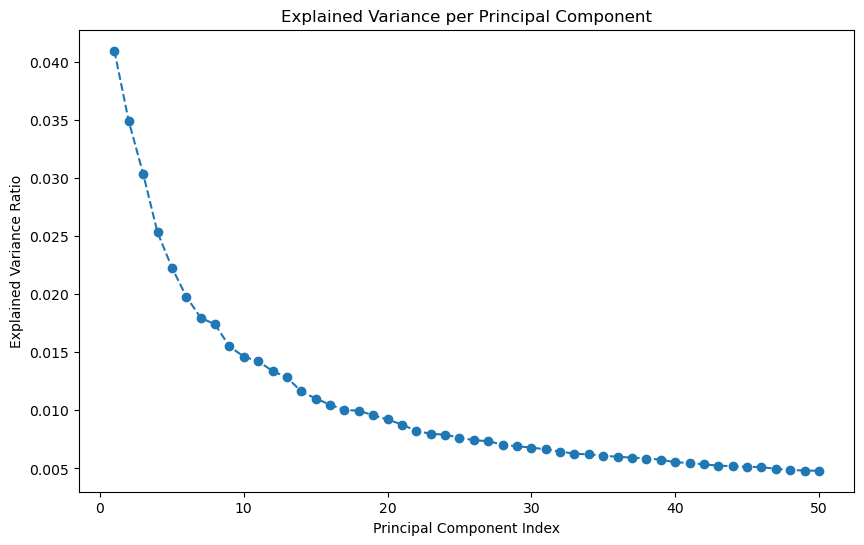

In [10]:
#Plotting the explained variance to visualize.

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Principal Component')
plt.show()

In [11]:
#Saving PCA
np.save('./Data/features_pca.npy', features_pca)

In [24]:
# Loading the EEG data and extracting EEG data array.

eeg_file = './Data/eeg_data.npy'
eeg_data = np.load(eeg_file, allow_pickle=True).item()


print("EEG Data Keys:", eeg_data.keys())
eeg_array = eeg_data['preprocessed_eeg_data']
print(f"EEG data shape: {eeg_array.shape}")

EEG Data Keys: dict_keys(['preprocessed_eeg_data', 'ch_names', 'times'])
EEG data shape: (16540, 4, 17, 100)


In [25]:
#Flattening the EEG Data.
#Matching EEG Data with PCA Features.

eeg_data_flat = eeg_array.reshape(eeg_array.shape[0], -1)
pca_features = np.load('./Data/features_pca.npy')

print(f"Flattened EEG data shape: {eeg_data_flat.shape}")
print(f"PCA features shape: {pca_features.shape}")

Flattened EEG data shape: (16540, 6800)
PCA features shape: (16540, 50)


In [26]:
#Performing Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(pca_features, eeg_data_flat, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Squared Error: 0.6313
R2 Score: 0.0003


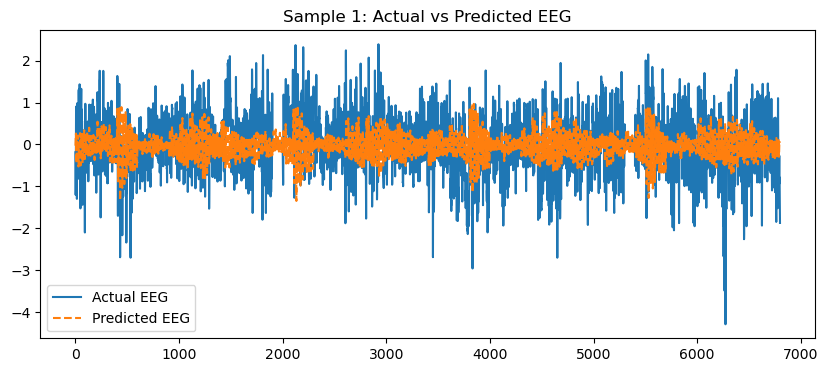

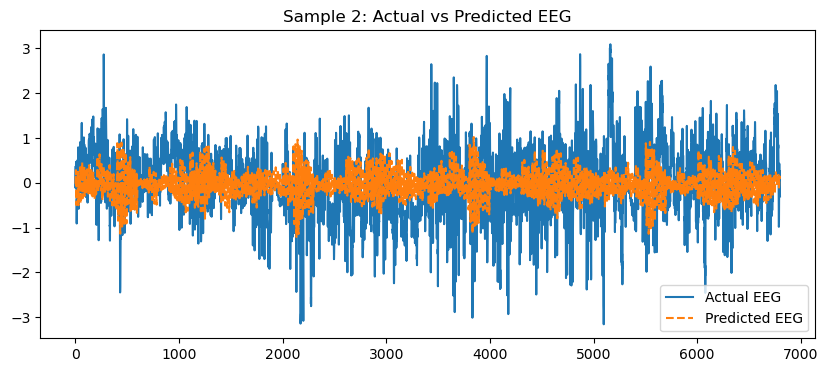

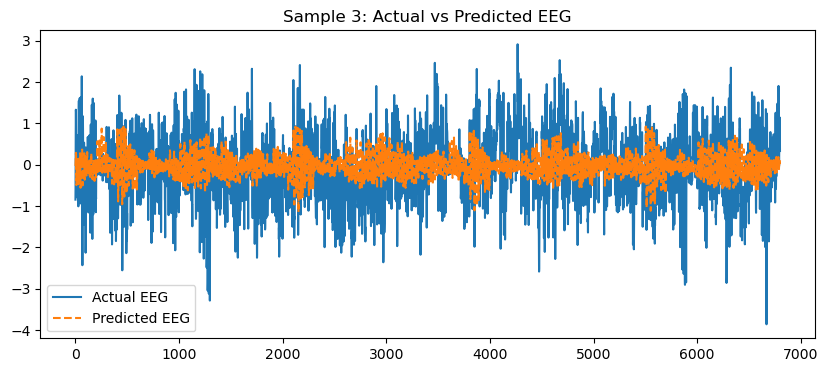

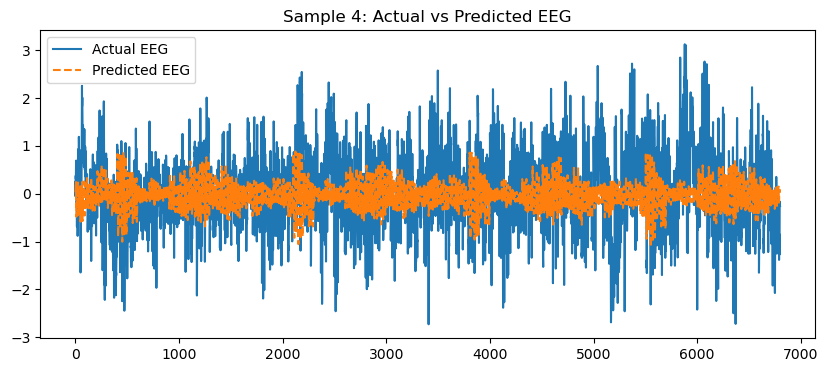

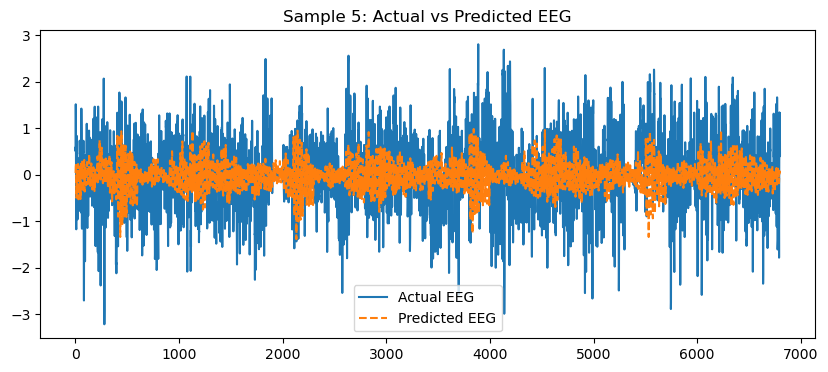

In [27]:
#Plotting the results.

for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test[i], label='Actual EEG')
    plt.plot(y_pred[i], label='Predicted EEG', linestyle='--')
    plt.title(f"Sample {i+1}: Actual vs Predicted EEG")
    plt.legend()
    plt.show()